Epoch [1/200], Loss: 929685696.0000
Epoch [2/200], Loss: 881883648.0000
Epoch [3/200], Loss: 802971712.0000
Epoch [4/200], Loss: 870202304.0000
Epoch [5/200], Loss: 803524800.0000
Epoch [6/200], Loss: 837849536.0000
Epoch [7/200], Loss: 905027776.0000
Epoch [8/200], Loss: 618816320.0000
Epoch [9/200], Loss: 809849152.0000
Epoch [10/200], Loss: 932048576.0000
Epoch [11/200], Loss: 647270848.0000
Epoch [12/200], Loss: 623220736.0000
Epoch [13/200], Loss: 705286848.0000
Epoch [14/200], Loss: 672304704.0000
Epoch [15/200], Loss: 652969536.0000
Epoch [16/200], Loss: 589333824.0000
Epoch [17/200], Loss: 559654080.0000
Epoch [18/200], Loss: 573955392.0000
Epoch [19/200], Loss: 446338688.0000
Epoch [20/200], Loss: 462201344.0000
Epoch [21/200], Loss: 424889120.0000
Epoch [22/200], Loss: 341570144.0000
Epoch [23/200], Loss: 323013248.0000
Epoch [24/200], Loss: 264329424.0000
Epoch [25/200], Loss: 292049024.0000
Epoch [26/200], Loss: 246961664.0000
Epoch [27/200], Loss: 232544464.0000
Epoch [28/

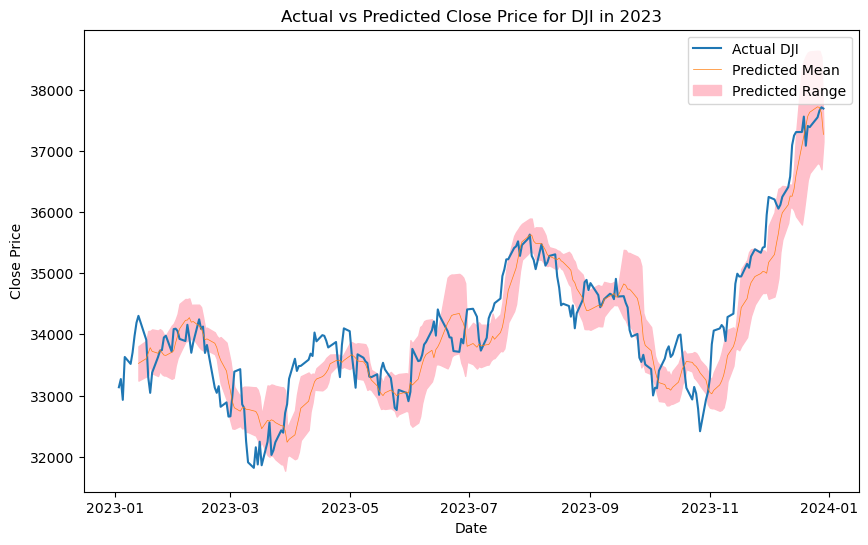

In [14]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# 道琼斯指数
ticker = "^DJI"
stock = yf.Ticker(ticker)
data = stock.history(period="1d", start="2018-01-01", end="2022-12-31")
data = data[data['Volume'] > 0]
data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

scaler = MinMaxScaler()
features_data = scaler.fit_transform(data[features])

def create_sequences(input_data, target_data, time_steps):
    X, Y = [], []
    for i in range(len(input_data) - time_steps):
        X.append(input_data[i:(i + time_steps)])
        Y.append(target_data[i + time_steps])
    return np.array(X), np.array(Y)

time_steps = 8
X, Y = create_sequences(features_data, data[target].values, time_steps)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

features_tensor = torch.Tensor(features_data)
targets_tensor = torch.Tensor(data[target].values)

dataset = TensorDataset(features_tensor, targets_tensor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model1 = SimpleNet(input_size=5, hidden_size=64, output_size=1)

optimizer = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 200
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model1(inputs)
        targets = targets.unsqueeze(1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 道琼斯指数2023年数据
data_2023 = stock.history(period="1d", start="2023-01-01", end="2023-12-31")
data_2023 = data_2023[data_2023['Volume'] > 0]
data_2023.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
features_data_2023 = scaler.transform(data_2023[features])

X_2023, Y_2023 = create_sequences(features_data_2023, data_2023[target].values, time_steps)
X_2023 = torch.Tensor(X_2023)

model1.eval()
with torch.no_grad():
    predictions_2023 = model1(X_2023)
predictions_2023 = predictions_2023.squeeze().numpy()
def r_squared(actual, predicted):
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
def mean_absolute_percentage_error(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) 

# 计算指标和绘制图表
mean_predictions_2023 = np.mean(predictions_2023, axis=1)
std_predictions_2023 = np.std(predictions_2023, axis=1)
diff = mean_predictions_2023 - data_2023[target].values[time_steps:]
mae = np.mean(np.abs(diff))
mse = np.mean(diff ** 2)
rmse = np.sqrt(mse)
r2 = r_squared(data_2023[target].values[time_steps:], mean_predictions_2023)
mape = mean_absolute_percentage_error(data_2023[target].values[time_steps:], mean_predictions_2023)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)
print("MAPE:", mape)

plt.figure(figsize=(10, 6))
plt.plot(data_2023.index, data_2023[target], label='Actual DJI')
plt.plot(data_2023.index[time_steps:], mean_predictions_2023, label='Predicted Mean', linewidth=0.5)
plt.fill_between(data_2023.index[time_steps:], mean_predictions_2023 - std_predictions_2023, mean_predictions_2023 + std_predictions_2023, color='pink', alpha=1, label='Predicted Range')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price for DJI in 2023')
plt.legend()
plt.show()
